In [1]:
!nvidia-smi

Fri Apr 16 12:32:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.72       Driver Version: 461.72       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208... WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   52C    P0    61W / 250W |   5692MiB / 11264MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import tensorflow as tf
import numpy as np
import cv2
import os
import importlib
import time
# import albumentations as albu

# from utils import cpm_utils

# CONFIG

Config stuff

In [6]:
class FLAGS(object):
    """ """
    """
    General settings
    """
    input_size = (1024, 1024)
    heatmap_size = 128
    cpm_stages = 4
    joint_gaussian_variance = 1.0
    center_radius = 21
    num_of_joints = 8
    color_channel = 'RGB'
    normalize = True
    use_gpu = True
    gpu_id = 0
    
    gradient_clipping = True # gradient clipping

    keypoints_order = ["TAIL_NOTCH",
                        "ADIPOSE_FIN",
                        "UPPER_LIP",
                        "ANAL_FIN",
                        "PELVIC_FIN",
                        "EYE",
                        "PECTORAL_FIN",
                        "DORSAL_FIN"]

    """
    Training settings
    """
    network_def = 'fish_test'
    train_img_dir = ''
    val_img_dir = ''
    bg_img_dir = ''
    pretrained_model = 'fish_test'
    batch_size = 4
    init_lr = 0.001
    lr_decay_rate = 0.5
    lr_decay_step = 10000
    steps_per_epoch = 2000
    val_steps_per_epochs = 500
    
    augmentation = None
    buffer_range = [int(n) for n in np.arange(100, 600, 100)] # useless if crop = False
    crop = False # crop input image based on keypoints - for GTSF only
#     augmentation = albu.Compose([albu.HorizontalFlip(p=0.5),
# #                                  albu.Rotate(limit=10, p=1.0)
#                                 ], 
#                                  p=1.0,
#                                  keypoint_params={'format': 'xy'})
    
    epochs=200

    hnm = True  # Make sure generate hnm files first
    do_cropping = True

    """
    For Freeze graphs
    """
    output_node_names = 'stage_3/mid_conv7/BiasAdd:0'
    validation_files = None
    training_files = None

In [7]:
cpm_model = importlib.import_module('models.nets.' + FLAGS.network_def)

ModuleNotFoundError: No module named 'models'

# MODEL CREATION

Creating a bunch of folder

In [6]:
from datetime import datetime

In [7]:
datenow = str(datetime.now()).split(".")[0].replace(" ","_").replace("-","_").replace(":","_")

In [8]:
base_dir = "/root/data/models/keypoints_detection/{}".format(datenow)

In [9]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

model_path_suffix = os.path.join(FLAGS.network_def,
                                 'input_{}_output_{}'.format(FLAGS.input_size, FLAGS.heatmap_size),
                                 'joints_{}'.format(FLAGS.num_of_joints),
                                 'stages_{}'.format(FLAGS.cpm_stages),
                                 'init_{}_rate_{}_step_{}'.format(FLAGS.init_lr, FLAGS.lr_decay_rate,
                                                                  FLAGS.lr_decay_step)
                                 )
model_save_dir = os.path.join(base_dir,
                              'weights')

Build network graph

In [10]:
model = cpm_model.CPM_Model(input_size=FLAGS.input_size,
                            heatmap_size=FLAGS.heatmap_size,
                            stages=FLAGS.cpm_stages,
                            joints=FLAGS.num_of_joints,
                            img_type=FLAGS.color_channel,
                            is_training=True)
model.build_loss(FLAGS.init_lr, 
                 FLAGS.lr_decay_rate, 
                 FLAGS.lr_decay_step, 
                 optimizer='RMSProp', 
                 clipping=FLAGS.gradient_clipping)
print('=====Model Build=====\n')

INFO:tensorflow:Summary name total loss train is illegal; using total_loss_train instead.
INFO:tensorflow:Summary name total loss eval is illegal; using total_loss_eval instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
INFO:tensorflow:Summary name global learning rate is illegal; using global_learning_rate instead.
=====Model Build=====



# DATA GENERATOR

Creating data generator. 

In [11]:
import glob
import json
import random

import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from utils.utils import DataGenerator

Using TensorFlow backend.


In [12]:
random.seed(193)

Load all the gtsf session

In [13]:
annotations = glob.glob('/root/data/bati/labels/labels_*')
print("Total number of days: {}".format(len(annotations)))

Total number of days: 36


Train - Val split. Let's split by experiment. Better practice

In [14]:
cutoff = int(len(annotations)*0.8)
random.shuffle(annotations)
train_files = annotations[:cutoff]
val_files = annotations[cutoff:]
print("Number of training files: {}".format(len(train_files)))
print("Number of validation files: {}".format(len(val_files)))

Number of training files: 28
Number of validation files: 8


In [15]:
train_annotations = []
for jpath in train_files:
    train_annotations += json.load(open(jpath))
print("Number of training data: {}".format(len(train_annotations)))
# train_annotations= [ann for ann in train_annotations if ann["species"] == "salmon"]
print("Number of training data: {}".format(len(train_annotations)))

for ann in train_annotations:
    ann['local_path'] = ann['local_path'].replace('/app', '/root')

Number of training data: 19936
Number of training data: 19936


In [16]:
val_annotations = []
for jpath in val_files:
    val_annotations += json.load(open(jpath))
print("Number of validation data: {}".format(len(val_annotations)))
# val_annotations = [ann for ann in val_annotations if ann["species"] == "salmon"]
print("Number of validation data: {}".format(len(val_annotations)))

for ann in val_annotations:
    ann['local_path'] = ann['local_path'].replace('/app', '/root')

Number of validation data: 5671
Number of validation data: 5671


In [17]:
paths = [d['local_path'] for d in val_annotations + train_annotations]

In [18]:
print(len(paths))
print(len(set(paths)))

25607
25607


In [19]:
FLAGS.validation_files = val_files
FLAGS.training_files = train_files

Create generator

In [20]:
import os
import cv2
import numpy as np
from utils.utils import load_image_keypoints, DataGenerator

Test the function

In [21]:
im, kps = load_image_keypoints(np.random.choice(val_annotations), FLAGS)

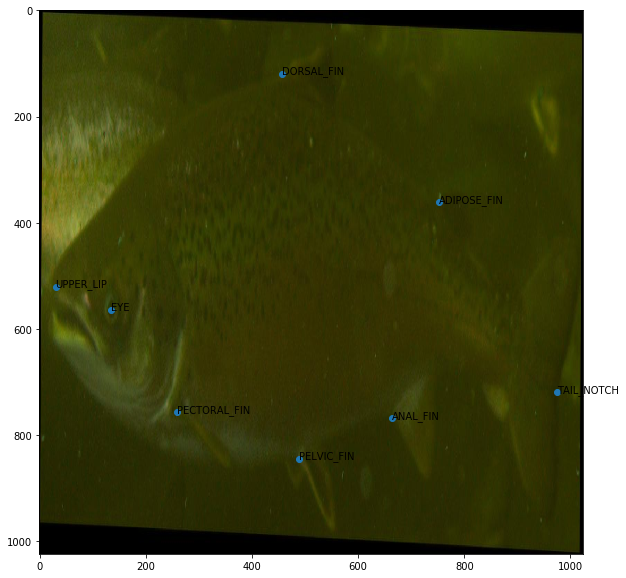

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(im)
plt.scatter(kps[:, 0], kps[:, 1])
for i in range(8):
    plt.text(kps[i, 0], kps[i,1], FLAGS.keypoints_order[i])
plt.show()

Create generator itself

In [23]:
train_generator = DataGenerator(train_annotations, FLAGS)
val_generator = DataGenerator(val_annotations, FLAGS)

In [24]:
xb, yb, heatmaps = val_generator[1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


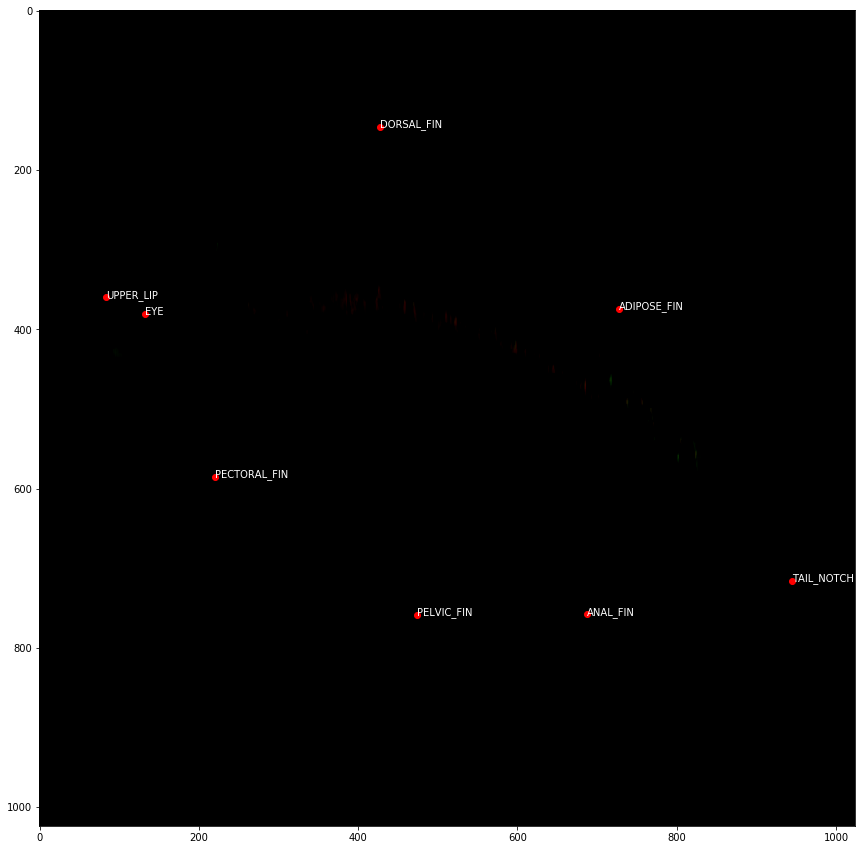

In [25]:
plt.figure(figsize=(15, 15))
plt.imshow(xb[1, ...])
i = 0
for kpp in yb[1]:
    plt.scatter(kpp[0], kpp[1], c="r")
    plt.text(kpp[0], kpp[1], FLAGS.keypoints_order[i], {"color": "w"})
    i += 1
plt.show()

In [26]:
from tqdm import tqdm

In [27]:
# for i in tqdm(np.random.randint(0, train_generator.__len__(), 200)):
#     xb, yb, heatmaps = train_generator[i]
#     print(xb.shape, yb.shape)

Augmentations

In [28]:
# plt.imshow(im)
# plt.show()
# results = FLAGS.augmentation(image=im, keypoints=list(kps.values()))
# nkps = np.array(results['keypoints'])
# plt.imshow(results["image"])
# plt.scatter(nkps[:, 0], nkps[:, 1])
# plt.show()

# TRAINING

In [29]:
if not os.path.isdir(model_save_dir):
    os.makedirs(model_save_dir)
print(model_save_dir)

/root/data/models/keypoints_detection/2019_05_30_18_27_12/weights


In [30]:
# save config
with open(os.path.join(base_dir, "config.json"), "w") as f:
    json.dump({k:v for (k,v) in FLAGS.__dict__.items() if k not in  ["__dict__", '__weakref__', 'augmentation']}, f)

In [31]:
def print_current_training_stats(global_step, cur_lr, stage_losses, total_loss, time_elapsed):
    stats = 'Step: {}/{} ----- Cur_lr: {:1.7f} ----- Time: {:>2.2f} sec.'.format(global_step, FLAGS.steps_per_epoch * FLAGS.epochs,
                                                                                 cur_lr, time_elapsed)
    losses = ' | '.join(
        ['S{} loss: {:>7.2f}'.format(stage_num + 1, stage_losses[stage_num]) for stage_num in range(FLAGS.cpm_stages)])
    losses += ' | Total loss: {}'.format(total_loss)
    print(stats)
    print(losses + '\n')

In [ ]:
merged_summary = tf.summary.merge_all()
device_count = {'GPU': 1} if FLAGS.use_gpu else {'GPU': 0}

# cause fuck tensorboard
history = {"train_stages_loss":[],
           "train_total_loss": [],
           "val_total_loss": [],
           "learning_rate": []}
with tf.Session(config=tf.ConfigProto(device_count=device_count,
                                      allow_soft_placement=True)) as sess:
#     # Create tensorboard
#     train_writer = tf.summary.FileWriter(train_log_save_dir, sess.graph)
#     test_writer = tf.summary.FileWriter(test_log_save_dir, sess.graph)
    
    # Create model saver
    saver = tf.train.Saver(max_to_keep=None) #max_to_keep=None)

    # Init all vars
    init_op = tf.global_variables_initializer()
    sess.run(init_op)
#     saver.restore(sess, '/root/data/models/keypoints_detection/2019_05_02_21_25_53/weights/fish_test-6')
    train_generator = DataGenerator(train_annotations, FLAGS)
    val_generator = DataGenerator(train_annotations, FLAGS)
    
    for epoch in range(FLAGS.epochs):
        print("Epoch {} starts. Number of training steps {}".format(epoch, FLAGS.steps_per_epoch))
        
        training_itr = 0
        
#         while training_itr < train_generator.__len__():
        while training_itr < FLAGS.steps_per_epoch:
            t1 = time.time()
            # load input + labels
            batch_x_np, _, batch_gt_heatmap_np = train_generator[training_itr]
            # print(time.time()-t1)
            training_itr += 1
            
            # Forward and update weights
            stage_losses_np, total_loss_np, _, summaries, current_lr, \
            stage_heatmap_np, global_step = sess.run([model.stage_loss,
                                                  model.total_loss,
                                                  model.train_op,
                                                  merged_summary,
                                                  model.cur_lr,
                                                  model.stage_heatmap,
                                                  model.global_step
                                                  ],
                                                 feed_dict={model.input_images: batch_x_np,
                                                            model.gt_hmap_placeholder: batch_gt_heatmap_np})
#             print(time.time()-t1)
            history["train_stages_loss"].append([float(s) for s in stage_losses_np])
            history["train_total_loss"].append(float(total_loss_np))
            history['learning_rate'].append(float(current_lr))
            # Show training info
            if global_step % 10 == 0:
                print_current_training_stats(global_step, current_lr, stage_losses_np, total_loss_np, time.time() - t1)
            
            # Write logs
            # train_writer.add_summary(summaries, epoch*training_itr)
        
        # shuffle on epoch end
        train_generator.on_epoch_end()
        
        saver.save(sess=sess, save_path=model_save_dir + '/' + FLAGS.network_def.split('.py')[0], 
                   global_step=epoch)
        print('\nModel checkpoint saved...\n')
        
        # now validation stuff
        mean_val_loss = 0
        val_itr = 0
        while val_itr < FLAGS.val_steps_per_epochs:
            print(val_itr)
            # load input + labels
            batch_x_np, _, batch_gt_heatmap_np = val_generator[val_itr]
            val_itr += 1
            
            val_total_loss, summaries = sess.run([model.total_loss, merged_summary],
                                                 feed_dict={model.input_images: batch_x_np,
                                                               model.gt_hmap_placeholder: batch_gt_heatmap_np})
            mean_val_loss += val_total_loss
            
        val_generator.on_epoch_end()
        val_mean_loss = mean_val_loss / FLAGS.val_steps_per_epochs
        history["val_total_loss"].append(float(val_mean_loss))
        print('\nValidation loss: {:>7.2f}\n'.format(val_mean_loss))
#         test_writer.add_summary(summaries, global_step)
        # save history
        with open(os.path.join(base_dir, "history.json"), "w") as f:
            json.dump(history, f)
        
        print("#"*100)

Epoch 0 starts. Number of training steps 2000
Step: 10/400000 ----- Cur_lr: 0.0009994 ----- Time: 1.75 sec.
S1 loss: 8051.64 | S2 loss: 7989.95 | S3 loss: 8027.12 | S4 loss: 8037.00 | Total loss: 32105.71875

Step: 20/400000 ----- Cur_lr: 0.0009987 ----- Time: 2.50 sec.
S1 loss: 7856.38 | S2 loss: 7678.43 | S3 loss: 7782.33 | S4 loss: 7809.48 | Total loss: 31126.619140625

Step: 30/400000 ----- Cur_lr: 0.0009980 ----- Time: 1.81 sec.
S1 loss: 7558.07 | S2 loss: 7199.94 | S3 loss: 7412.97 | S4 loss: 7465.03 | Total loss: 29636.00390625

Step: 40/400000 ----- Cur_lr: 0.0009973 ----- Time: 1.88 sec.
S1 loss: 7125.09 | S2 loss: 6478.84 | S3 loss: 6868.71 | S4 loss: 6960.49 | Total loss: 27433.134765625

Step: 50/400000 ----- Cur_lr: 0.0009966 ----- Time: 1.90 sec.
S1 loss: 6505.61 | S2 loss: 5309.02 | S3 loss: 6035.65 | S4 loss: 6207.75 | Total loss: 24058.03125

Step: 60/400000 ----- Cur_lr: 0.0009959 ----- Time: 1.84 sec.
S1 loss: 5642.61 | S2 loss: 2629.43 | S3 loss: 4085.02 | S4 loss: 

Step: 500/400000 ----- Cur_lr: 0.0009660 ----- Time: 1.83 sec.
S1 loss:   25.49 | S2 loss:   27.06 | S3 loss:   26.12 | S4 loss:   25.67 | Total loss: 104.35155487060547

Step: 510/400000 ----- Cur_lr: 0.0009653 ----- Time: 1.82 sec.
S1 loss:   25.18 | S2 loss:   25.61 | S3 loss:   25.44 | S4 loss:   25.18 | Total loss: 101.41667175292969

Step: 520/400000 ----- Cur_lr: 0.0009647 ----- Time: 1.86 sec.
S1 loss:   25.54 | S2 loss:   26.50 | S3 loss:   25.70 | S4 loss:   25.40 | Total loss: 103.14802551269531

Step: 530/400000 ----- Cur_lr: 0.0009640 ----- Time: 1.86 sec.
S1 loss:   25.00 | S2 loss:   25.81 | S3 loss:   25.07 | S4 loss:   25.48 | Total loss: 101.35066223144531

Step: 540/400000 ----- Cur_lr: 0.0009633 ----- Time: 1.84 sec.
S1 loss:   25.34 | S2 loss:   26.02 | S3 loss:   25.26 | S4 loss:   25.35 | Total loss: 101.96878814697266

Step: 550/400000 ----- Cur_lr: 0.0009627 ----- Time: 1.88 sec.
S1 loss:   25.11 | S2 loss:   25.45 | S3 loss:   25.66 | S4 loss:   25.59 | Total 

Step: 990/400000 ----- Cur_lr: 0.0009337 ----- Time: 1.82 sec.
S1 loss:   27.46 | S2 loss:   27.46 | S3 loss:   26.27 | S4 loss:   28.06 | Total loss: 109.26512145996094

Step: 1000/400000 ----- Cur_lr: 0.0009331 ----- Time: 1.85 sec.
S1 loss:   26.29 | S2 loss:   26.68 | S3 loss:   26.97 | S4 loss:   27.97 | Total loss: 107.90335083007812

Step: 1010/400000 ----- Cur_lr: 0.0009325 ----- Time: 1.83 sec.
S1 loss:   26.36 | S2 loss:   26.44 | S3 loss:   26.34 | S4 loss:   27.27 | Total loss: 106.4014892578125

Step: 1020/400000 ----- Cur_lr: 0.0009318 ----- Time: 1.84 sec.
S1 loss:   25.58 | S2 loss:   26.51 | S3 loss:   26.08 | S4 loss:   26.67 | Total loss: 104.8311767578125

Step: 1030/400000 ----- Cur_lr: 0.0009312 ----- Time: 1.81 sec.
S1 loss:   25.75 | S2 loss:   25.96 | S3 loss:   25.73 | S4 loss:   26.52 | Total loss: 103.96099090576172

Step: 1040/400000 ----- Cur_lr: 0.0009305 ----- Time: 1.86 sec.
S1 loss:   25.30 | S2 loss:   25.74 | S3 loss:   25.44 | S4 loss:   25.95 | Tot

Step: 1470/400000 ----- Cur_lr: 0.0009032 ----- Time: 1.83 sec.
S1 loss:   25.96 | S2 loss:   25.51 | S3 loss:   25.50 | S4 loss:   25.77 | Total loss: 102.73231506347656

Step: 1480/400000 ----- Cur_lr: 0.0009026 ----- Time: 1.84 sec.
S1 loss:   26.04 | S2 loss:   25.32 | S3 loss:   25.29 | S4 loss:   25.25 | Total loss: 101.905517578125

Step: 1490/400000 ----- Cur_lr: 0.0009019 ----- Time: 1.83 sec.
S1 loss:   25.63 | S2 loss:   25.32 | S3 loss:   25.14 | S4 loss:   25.51 | Total loss: 101.60597229003906

Step: 1500/400000 ----- Cur_lr: 0.0009013 ----- Time: 1.84 sec.
S1 loss:   25.29 | S2 loss:   25.45 | S3 loss:   25.32 | S4 loss:   25.21 | Total loss: 101.27308654785156

Step: 1510/400000 ----- Cur_lr: 0.0009007 ----- Time: 1.85 sec.
S1 loss:   25.22 | S2 loss:   25.10 | S3 loss:   25.21 | S4 loss:   25.45 | Total loss: 100.98579406738281

Step: 1520/400000 ----- Cur_lr: 0.0009001 ----- Time: 1.82 sec.
S1 loss:   25.32 | S2 loss:   25.21 | S3 loss:   25.47 | S4 loss:   25.32 | To

Step: 1950/400000 ----- Cur_lr: 0.0008736 ----- Time: 1.81 sec.
S1 loss:   25.29 | S2 loss:   25.10 | S3 loss:   25.17 | S4 loss:   25.14 | Total loss: 100.69258117675781

Step: 1960/400000 ----- Cur_lr: 0.0008730 ----- Time: 1.83 sec.
S1 loss:   25.28 | S2 loss:   25.19 | S3 loss:   25.15 | S4 loss:   25.20 | Total loss: 100.81101989746094

Step: 1970/400000 ----- Cur_lr: 0.0008724 ----- Time: 1.84 sec.
S1 loss:   25.44 | S2 loss:   25.18 | S3 loss:   25.12 | S4 loss:   25.20 | Total loss: 100.9437484741211

Step: 1980/400000 ----- Cur_lr: 0.0008718 ----- Time: 1.88 sec.
S1 loss:   25.19 | S2 loss:   25.22 | S3 loss:   25.14 | S4 loss:   25.25 | Total loss: 100.80696105957031

Step: 1990/400000 ----- Cur_lr: 0.0008712 ----- Time: 1.83 sec.
S1 loss:   25.20 | S2 loss:   25.28 | S3 loss:   25.18 | S4 loss:   25.46 | Total loss: 101.11700439453125

Step: 2000/400000 ----- Cur_lr: 0.0008706 ----- Time: 1.85 sec.
S1 loss:   25.42 | S2 loss:   25.24 | S3 loss:   25.12 | S4 loss:   25.39 | T

Step: 2300/400000 ----- Cur_lr: 0.0008527 ----- Time: 1.85 sec.
S1 loss:   25.12 | S2 loss:   25.20 | S3 loss:   25.16 | S4 loss:   25.24 | Total loss: 100.7230224609375

Step: 2310/400000 ----- Cur_lr: 0.0008521 ----- Time: 1.87 sec.
S1 loss:   25.33 | S2 loss:   25.38 | S3 loss:   25.27 | S4 loss:   25.28 | Total loss: 101.26947021484375

Step: 2320/400000 ----- Cur_lr: 0.0008515 ----- Time: 1.83 sec.
S1 loss:   25.14 | S2 loss:   25.24 | S3 loss:   25.19 | S4 loss:   25.22 | Total loss: 100.79532623291016

Step: 2330/400000 ----- Cur_lr: 0.0008509 ----- Time: 1.79 sec.
S1 loss:   25.20 | S2 loss:   25.13 | S3 loss:   25.17 | S4 loss:   25.15 | Total loss: 100.64942932128906

Step: 2340/400000 ----- Cur_lr: 0.0008503 ----- Time: 1.86 sec.
S1 loss:   25.40 | S2 loss:   25.14 | S3 loss:   25.16 | S4 loss:   25.11 | Total loss: 100.81082153320312

Step: 2350/400000 ----- Cur_lr: 0.0008497 ----- Time: 1.87 sec.
S1 loss:   25.21 | S2 loss:   25.30 | S3 loss:   25.19 | S4 loss:   25.27 | T

Step: 2780/400000 ----- Cur_lr: 0.0008248 ----- Time: 1.80 sec.
S1 loss:   25.18 | S2 loss:   25.13 | S3 loss:   25.10 | S4 loss:   25.13 | Total loss: 100.53507995605469

Step: 2790/400000 ----- Cur_lr: 0.0008242 ----- Time: 1.87 sec.
S1 loss:   25.18 | S2 loss:   25.16 | S3 loss:   25.10 | S4 loss:   25.13 | Total loss: 100.57096862792969

Step: 2800/400000 ----- Cur_lr: 0.0008236 ----- Time: 1.80 sec.
S1 loss:   25.10 | S2 loss:   25.19 | S3 loss:   25.14 | S4 loss:   25.22 | Total loss: 100.65460205078125

Step: 2810/400000 ----- Cur_lr: 0.0008231 ----- Time: 1.79 sec.
S1 loss:   25.13 | S2 loss:   25.14 | S3 loss:   25.15 | S4 loss:   25.14 | Total loss: 100.55946350097656

Step: 2820/400000 ----- Cur_lr: 0.0008225 ----- Time: 1.84 sec.
S1 loss:   25.01 | S2 loss:   25.00 | S3 loss:   24.96 | S4 loss:   25.18 | Total loss: 100.14723205566406

Step: 2830/400000 ----- Cur_lr: 0.0008219 ----- Time: 1.82 sec.
S1 loss:   25.20 | S2 loss:   25.10 | S3 loss:   25.15 | S4 loss:   25.13 | 

Step: 3260/400000 ----- Cur_lr: 0.0007978 ----- Time: 1.86 sec.
S1 loss:   25.19 | S2 loss:   25.16 | S3 loss:   25.09 | S4 loss:   25.12 | Total loss: 100.56321716308594

Step: 3270/400000 ----- Cur_lr: 0.0007972 ----- Time: 1.82 sec.
S1 loss:   25.22 | S2 loss:   25.08 | S3 loss:   25.09 | S4 loss:   25.13 | Total loss: 100.52391052246094

Step: 3280/400000 ----- Cur_lr: 0.0007967 ----- Time: 1.88 sec.
S1 loss:   25.18 | S2 loss:   25.20 | S3 loss:   25.13 | S4 loss:   25.14 | Total loss: 100.65184020996094

Step: 3290/400000 ----- Cur_lr: 0.0007961 ----- Time: 1.75 sec.
S1 loss:   25.20 | S2 loss:   25.12 | S3 loss:   25.08 | S4 loss:   25.12 | Total loss: 100.52537536621094

Step: 3300/400000 ----- Cur_lr: 0.0007956 ----- Time: 1.80 sec.
S1 loss:   25.22 | S2 loss:   25.10 | S3 loss:   25.08 | S4 loss:   25.11 | Total loss: 100.52188110351562

Step: 3310/400000 ----- Cur_lr: 0.0007950 ----- Time: 1.88 sec.
S1 loss:   25.16 | S2 loss:   25.14 | S3 loss:   25.10 | S4 loss:   25.15 | 

Step: 3740/400000 ----- Cur_lr: 0.0007717 ----- Time: 1.89 sec.
S1 loss:   25.47 | S2 loss:   25.29 | S3 loss:   25.22 | S4 loss:   25.20 | Total loss: 101.18125915527344

Step: 3750/400000 ----- Cur_lr: 0.0007712 ----- Time: 1.82 sec.
S1 loss:   25.21 | S2 loss:   25.12 | S3 loss:   25.09 | S4 loss:   25.16 | Total loss: 100.58282470703125

Step: 3760/400000 ----- Cur_lr: 0.0007706 ----- Time: 1.93 sec.
S1 loss:   25.18 | S2 loss:   25.11 | S3 loss:   25.15 | S4 loss:   25.14 | Total loss: 100.58738708496094

Step: 3770/400000 ----- Cur_lr: 0.0007701 ----- Time: 1.88 sec.
S1 loss:   25.16 | S2 loss:   25.16 | S3 loss:   25.08 | S4 loss:   25.11 | Total loss: 100.50275421142578

Step: 3780/400000 ----- Cur_lr: 0.0007696 ----- Time: 1.81 sec.
S1 loss:   25.16 | S2 loss:   25.10 | S3 loss:   25.07 | S4 loss:   25.10 | Total loss: 100.42334747314453

Step: 3790/400000 ----- Cur_lr: 0.0007690 ----- Time: 1.83 sec.
S1 loss:   25.13 | S2 loss:   25.16 | S3 loss:   25.07 | S4 loss:   25.19 | 

Step: 4090/400000 ----- Cur_lr: 0.0007532 ----- Time: 1.87 sec.
S1 loss:   25.10 | S2 loss:   25.10 | S3 loss:   25.08 | S4 loss:   25.09 | Total loss: 100.37138366699219

Step: 4100/400000 ----- Cur_lr: 0.0007527 ----- Time: 1.96 sec.
S1 loss:   25.24 | S2 loss:   25.16 | S3 loss:   25.10 | S4 loss:   25.12 | Total loss: 100.61727905273438

Step: 4110/400000 ----- Cur_lr: 0.0007522 ----- Time: 1.84 sec.
S1 loss:   25.35 | S2 loss:   25.19 | S3 loss:   25.14 | S4 loss:   25.16 | Total loss: 100.8379898071289

Step: 4120/400000 ----- Cur_lr: 0.0007516 ----- Time: 1.75 sec.
S1 loss:   25.13 | S2 loss:   25.14 | S3 loss:   25.12 | S4 loss:   25.20 | Total loss: 100.58585357666016

Step: 4130/400000 ----- Cur_lr: 0.0007511 ----- Time: 1.86 sec.
S1 loss:   25.03 | S2 loss:   25.00 | S3 loss:   25.03 | S4 loss:   25.03 | Total loss: 100.09944915771484

Step: 4140/400000 ----- Cur_lr: 0.0007506 ----- Time: 1.83 sec.
S1 loss:   25.17 | S2 loss:   25.08 | S3 loss:   25.14 | S4 loss:   25.11 | T

Step: 4570/400000 ----- Cur_lr: 0.0007286 ----- Time: 1.80 sec.
S1 loss:   25.17 | S2 loss:   25.12 | S3 loss:   25.13 | S4 loss:   26.00 | Total loss: 101.41387939453125

Step: 4580/400000 ----- Cur_lr: 0.0007280 ----- Time: 1.75 sec.
S1 loss:   25.14 | S2 loss:   25.82 | S3 loss:   26.14 | S4 loss:   25.39 | Total loss: 102.4893798828125

Step: 4590/400000 ----- Cur_lr: 0.0007275 ----- Time: 1.88 sec.
S1 loss:   25.46 | S2 loss:   25.63 | S3 loss:   25.28 | S4 loss:   25.48 | Total loss: 101.85342407226562

Step: 4600/400000 ----- Cur_lr: 0.0007270 ----- Time: 1.85 sec.
S1 loss:   25.44 | S2 loss:   25.34 | S3 loss:   25.22 | S4 loss:   25.49 | Total loss: 101.48995971679688

Step: 4610/400000 ----- Cur_lr: 0.0007265 ----- Time: 1.80 sec.
S1 loss:   25.36 | S2 loss:   25.37 | S3 loss:   25.10 | S4 loss:   25.16 | Total loss: 100.9939193725586

Step: 4620/400000 ----- Cur_lr: 0.0007260 ----- Time: 1.87 sec.
S1 loss:   25.39 | S2 loss:   25.42 | S3 loss:   25.26 | S4 loss:   25.26 | To

Step: 5050/400000 ----- Cur_lr: 0.0007047 ----- Time: 1.84 sec.
S1 loss:   25.09 | S2 loss:   25.05 | S3 loss:   25.00 | S4 loss:   25.08 | Total loss: 100.20833587646484

Step: 5060/400000 ----- Cur_lr: 0.0007042 ----- Time: 1.84 sec.
S1 loss:   25.25 | S2 loss:   25.10 | S3 loss:   25.18 | S4 loss:   25.14 | Total loss: 100.66950225830078

Step: 5070/400000 ----- Cur_lr: 0.0007037 ----- Time: 1.84 sec.
S1 loss:   25.15 | S2 loss:   25.10 | S3 loss:   25.08 | S4 loss:   25.10 | Total loss: 100.43099975585938

Step: 5080/400000 ----- Cur_lr: 0.0007032 ----- Time: 1.86 sec.
S1 loss:   25.07 | S2 loss:   25.06 | S3 loss:   24.92 | S4 loss:   24.94 | Total loss: 99.99348449707031

Step: 5090/400000 ----- Cur_lr: 0.0007028 ----- Time: 1.84 sec.
S1 loss:   25.12 | S2 loss:   25.17 | S3 loss:   25.08 | S4 loss:   25.10 | Total loss: 100.4710464477539

Step: 5100/400000 ----- Cur_lr: 0.0007023 ----- Time: 1.82 sec.
S1 loss:   25.15 | S2 loss:   25.09 | S3 loss:   25.09 | S4 loss:   25.11 | To

In [ ]:
cur_lr = tf.train.exponential_decay(0.001,
                                     global_step=10,
                                     decay_rate=0.5,
                                     decay_steps=10000)

In [ ]:
op = sess.graph.get_operations()
[m.values() for m in op]

Some visualization code

In [ ]:
final_stage_heatmap = stage_heatmap_np[-1][0, ...]
print(final_stage_heatmap.shape)
f, ax = plt.subplots(5, 2, figsize=(20, 30))
c = 0
for i in range(5):
    for j in range(2):
        if c == 9:
            continue
        hm = cv2.resize(final_stage_heatmap[..., c], FLAGS.input_size)
        hm_max = np.where(hm == hm.max())
        ax[i,j].imshow(xb[0, ...])
        ax[i,j].imshow(hm, alpha=0.5)
        ax[i,j].scatter(hm_max[1], hm_max[0], c="r")
        ax[i,j].axis("off")
        c+=1
plt.show()